In [1]:
import os
from pathlib import Path
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)




Using TensorFlow backend.


In [2]:
#df=pd.read_csv("C:\\Users\\ASPiRE F5\\Desktop\\denoising-dirty-documents\\sampleSubmission.csv",engine='python')
#print(df)
#print(check_output(["ls","C:\\Users\\ASPiRE F5\\Desktop\\denoising-dirty-documents"]).decode("utf8"))
input_dir  = Path('C:\\Users\\ASPiRE F5\\Desktop\\denoising-dirty-documents\\')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [3]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))


Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


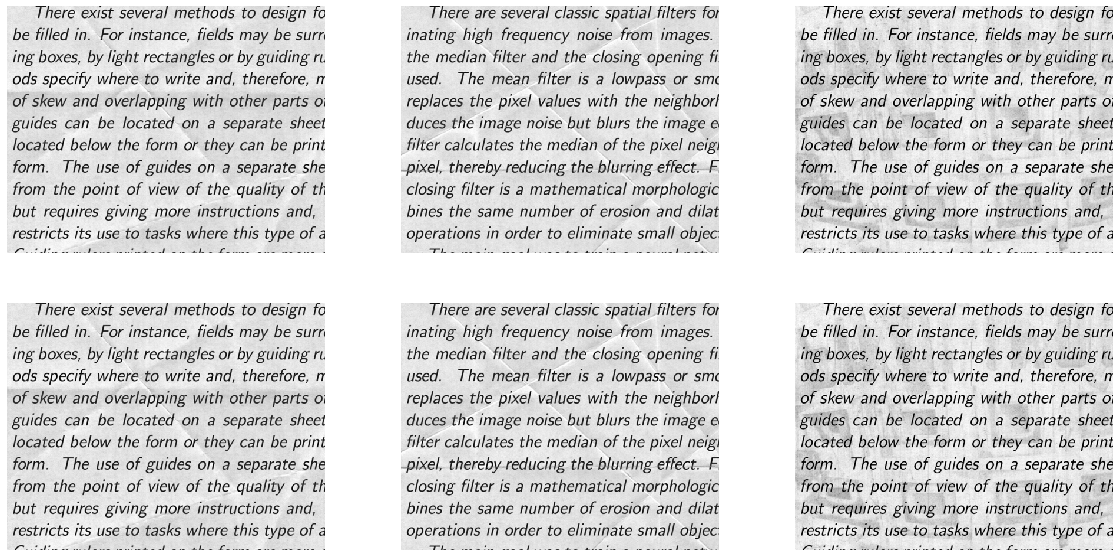

In [4]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()

In [5]:
t=train_images[:1]
im=str(t[0])
img=imread(train/im)
print(np.size(img,0),np.size(img,1))

420 540


In [8]:
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    #x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv3')(x)
    #x = MaxPooling2D((2,2), padding='same', name='pool3')(x)
    
    #decoder
    #x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv4')(x)
    #x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv5')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv6')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv7')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [9]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv5 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample2 (UpSampling2D)     (None, 210, 270, 64)      0   

In [10]:
X=[]
Y = []

for img in train_images:
    img = load_img(train / img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, color_mode = "grayscale",target_size=(420,540))
    img=img.resize([540,420])
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [13]:
%%time
autoencoder.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/50
129/129 [==============================] - 8s 62ms/step - loss: 0.3475 - val_loss: 0.3370
Epoch 2/50
129/129 [==============================] - 8s 62ms/step - loss: 0.3043 - val_loss: 0.2690
Epoch 3/50
129/129 [==============================] - 8s 62ms/step - loss: 0.2459 - val_loss: 0.2348
Epoch 4/50
129/129 [==============================] - 8s 62ms/step - loss: 0.2172 - val_loss: 0.2132
Epoch 5/50
129/129 [==============================] - 8s 62ms/step - loss: 0.1946 - val_loss: 0.2023
Epoch 6/50
129/129 [==============================] - 8s 62ms/step - loss: 0.1811 - val_loss: 0.1852
Epoch 7/50
129/129 [==============================] - 8s 62ms/step - loss: 0.1711 - val_loss: 0.1757
Epoch 8/50
129/129 [==============================] - 8s 62ms/step - loss: 0.1631 - val_loss: 0.1683
Epoch 9/50
129/129 [==============================] - 8s 62ms/step - loss: 0.1572 - val_loss: 0.1628
Epoch 10/50
129/129 [=========================

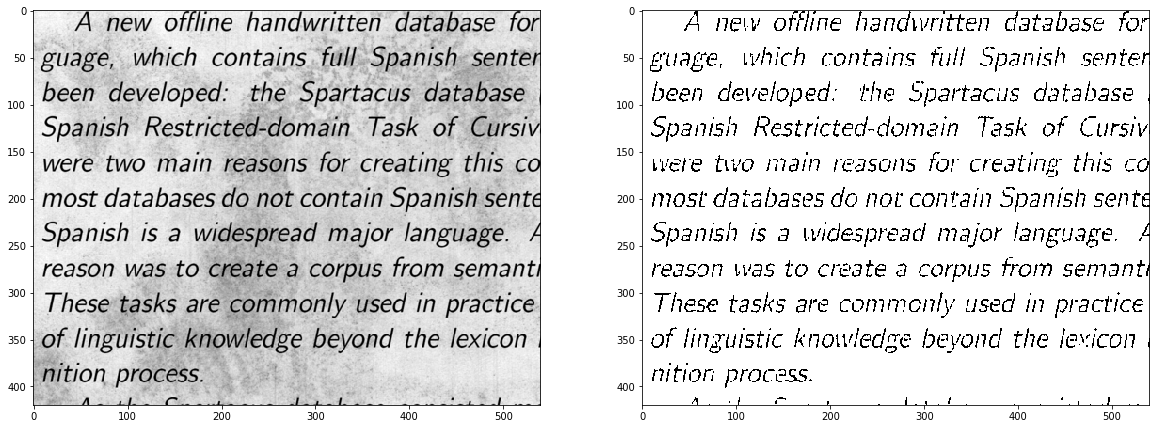

In [15]:
sample_test = load_img(test/ test_images[3], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(20,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In [16]:
import pickle
filename = 'finalized4_model.sav'
pickle.dump(autoencoder, open(filename, 'wb'))